In [2]:
%matplotlib notebook
%config Completer.use_jedi = False
import tensorflow as tf
import numpy as np
import keras
import matplotlib.pyplot as plt
import gym

# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [3]:
# Loading the Lunar lander module 
env=gym.make("LunarLander-v2")
obs=env.reset()
obs
# The coordinates of the landing location are (0,0) the first two numbers in state vector are the coordinates of the lander
# in the state vector (position x, position y), then comes the horizontal velocity of lander, vertical velocity of lander, 
# lander angle, lander angular velocity lander leg1 ground contact, lander leg2 ground contact

array([ 0.00577345,  1.4044659 ,  0.58477086, -0.28687376, -0.00668319,
       -0.13245942,  0.        ,  0.        ], dtype=float32)

In [4]:
# Let's take a look at the action space for the enviorment
# 4 actions, 0-do nothing, 1-fire left (move right), 2-fire main engine (move up), 3 fire right engine (move left)
env.action_space

Discrete(4)

In [5]:
# Creating DQN keras model
env=gym.make("LunarLander-v2")
input_shape=[env.observation_space.shape[0]]
n_outputs=4

model=keras.models.Sequential([
    keras.layers.Dense(144,activation="elu",input_shape=input_shape),
    keras.layers.Dense(n_outputs)
])

In [6]:
# Implementing a greddy epsilon policy
def epsilon_greedy_policy(state,epsilon=0):
    if np.random.rand() < epsilon:
        return np.random.randint(4)
    else:
        Q_values=model.predict(state[np.newaxis])
        return np.argmax(Q_values[0])

In [7]:
# Creating replay buffer
from collections import deque
replay_buffer=deque(maxlen=2000)

In [8]:
# Sampling random batch from replay buffer
def sample_experience(batch_size):
    indices=np.random.randint(len(replay_buffer),size=batch_size)
    batch=[replay_buffer[index] for index in indices]
    states,actions,rewards,next_states,dones=[np.array([experience[field_index] for experience in batch]) for 
                                              field_index in range(5)]
    return states,actions,rewards,next_states,dones

In [9]:
#Creating function that will play single step using epsilon greedy policy then store experience
def play_one_step(env,state,epsilon,step):
    action=epsilon_greedy_policy(state,epsilon)
    next_state,reward,done,info=env.step(action)
# Below I added in negative rewards if the episode hadn't finished after the 100th steps, this was to counteract
# the effect of the model taking too long to land/ this proved determinetanl as after implementation model began a rapid
# but uncontrolled descent in some episodes, leading to failing the exercise. I did vary the steps and rewards but did not
# achieve a satisfactory benefit from below line, hence removed
#     if step>100:
#         reward+=-5
    replay_buffer.append((state,action,reward,next_state,done))
    return next_state,reward,done,info

In [10]:
# Model that will sample batch from the replay buffer and then train the model
batch_size=32
discount_factor=0.97
optimizer=keras.optimizers.Adam(lr=1e-3)
loss_fn=keras.losses.mean_absolute_error

def training_step(batch_size):
    experiences=sample_experience(batch_size)
    states,actions,rewards,next_states,dones=experiences
    next_Q_values=model.predict(next_states)
    max_next_Q_values=np.max(next_Q_values,axis=1)
    target_Q_values=(rewards+(1-done) * discount_factor * max_next_Q_values)
    target_Q_values=target_Q_values.reshape(-1,1)
    mask=tf.one_hot(actions,n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values=model(states)
        Q_values=tf.reduce_sum(all_Q_values * mask,axis=1,keepdims=True)
        loss=tf.reduce_mean(loss_fn(target_Q_values,Q_values))
        grads=tape.gradient(loss,model.trainable_variables)
        optimizer.apply_gradients(zip(grads,model.trainable_variables))

In [11]:
# Training the model
cease=False
for episode in range(2000):
    if cease:
        break
    obs=env.reset()
    done=False
    episode_reward=0
    step=1
    while not done:
        epsilon=max(1-episode/500,0.01)
        obs,reward,done,info=play_one_step(env,obs,epsilon,step)
        episode_reward+=reward
        step+=1
        if done:
            if episode_reward>225:
                cease=True
            print("Episode number {}, score for last episode was {}".format(episode,episode_reward))
            break
        if episode > 50:
            training_step(batch_size)

Episode number 0, score for last episode was -391.97960734398606
Episode number 1, score for last episode was -129.6918117915533
Episode number 2, score for last episode was -116.30925205597705
Episode number 3, score for last episode was -302.03720604205733
Episode number 4, score for last episode was -97.43630658357561
Episode number 5, score for last episode was -84.54870752186406
Episode number 6, score for last episode was -140.37073991138516
Episode number 7, score for last episode was -429.0428894679401
Episode number 8, score for last episode was -212.5135050323867
Episode number 9, score for last episode was -119.0041251327437
Episode number 10, score for last episode was -109.61641816298773
Episode number 11, score for last episode was -259.6303671928057
Episode number 12, score for last episode was -149.9330617175205
Episode number 13, score for last episode was -90.6082842153147
Episode number 14, score for last episode was -107.96687030033829
Episode number 15, score for l

Episode number 126, score for last episode was -63.70714238798273
Episode number 127, score for last episode was -102.43063511857552
Episode number 128, score for last episode was -81.85098196930082
Episode number 129, score for last episode was -121.44246943363308
Episode number 130, score for last episode was -78.00966422513622
Episode number 131, score for last episode was -95.0488159515039
Episode number 132, score for last episode was -90.52512991772954
Episode number 133, score for last episode was -61.02332636859531
Episode number 134, score for last episode was -72.03175722837835
Episode number 135, score for last episode was -97.84256878758711
Episode number 136, score for last episode was -110.90700126553466
Episode number 137, score for last episode was -22.701474394537527
Episode number 138, score for last episode was -102.38744114341789
Episode number 139, score for last episode was -78.50067043775624
Episode number 140, score for last episode was -171.15524819209125
Episo

Episode number 250, score for last episode was 11.452414045769714
Episode number 251, score for last episode was -157.9016509995159
Episode number 252, score for last episode was -77.87725857138753
Episode number 253, score for last episode was -18.667286633091507
Episode number 254, score for last episode was 83.89596507806574
Episode number 255, score for last episode was -7.127015248919889
Episode number 256, score for last episode was -18.267826811696096
Episode number 257, score for last episode was -211.76735201607232
Episode number 258, score for last episode was 43.456902504694455
Episode number 259, score for last episode was -75.9053312336884
Episode number 260, score for last episode was -120.95522485159131
Episode number 261, score for last episode was -97.85590735053869
Episode number 262, score for last episode was -47.875361221332284
Episode number 263, score for last episode was -59.88818799436394
Episode number 264, score for last episode was -32.69044182211471
Episode

Episode number 375, score for last episode was 81.85502318325229
Episode number 376, score for last episode was -46.730770796233266
Episode number 377, score for last episode was -98.59765730507647
Episode number 378, score for last episode was -71.18005529768052
Episode number 379, score for last episode was 2.0598010238633577
Episode number 380, score for last episode was -102.00726480400328
Episode number 381, score for last episode was 207.73135818679708
Episode number 382, score for last episode was -7.49755415049782
Episode number 383, score for last episode was -6.678531724410446
Episode number 384, score for last episode was 56.38623738049196
Episode number 385, score for last episode was 79.52763578966038
Episode number 386, score for last episode was 60.7917062642323
Episode number 387, score for last episode was 103.60512470030172
Episode number 388, score for last episode was 103.12978005801055
Episode number 389, score for last episode was 130.06605752658808
Episode number

In [31]:
# Let's first take a look at a random choice model
import gym
env = gym.make("LunarLander-v2")
for i_episode in range(3):
    obs = env.reset()
    for t in range(1000):
        env.render()
        action=np.random.choice([0,1,2,3])
        obs, reward, done, info = env.step(action)
        env.render()
        if done:
            for t_d in range(10):
                env.render()
                action=0
                env.step(action)
                env.render()
            print("Episode finished after {} timesteps".format(t+1))
            break
env.close()

Episode finished after 108 timesteps
Episode finished after 80 timesteps
Episode finished after 106 timesteps


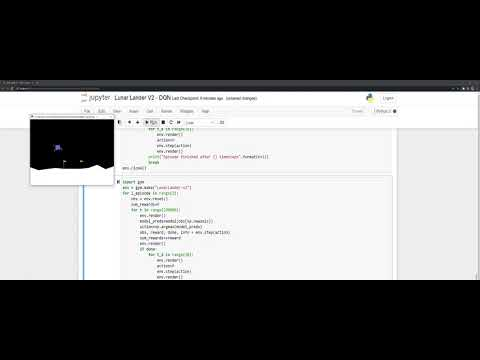

In [46]:
from IPython.display import YouTubeVideo

YouTubeVideo('czY-HYGNmss', width=800, height=300)

In [42]:
# Let's now test the model
import gym
env = gym.make("LunarLander-v2")
for i_episode in range(1):
    obs = env.reset()
    sum_rewards=0
    for t in range(100000):
        env.render()
        model_preds=model(obs[np.newaxis])
        action=np.argmax(model_preds) 
        obs, reward, done, info = env.step(action)
        sum_rewards+=reward
        env.render()
        if done:
            for t_d in range(10):
                env.render()
                action=0
                env.step(action)
                env.render()
            print("Episode finished after {} timesteps, reward for that run was {}".format(t+1,sum_rewards))
            break
env.close()

Episode finished after 337 timesteps, reward for that run was 247.48466863080083


In [48]:
from IPython.display import YouTubeVideo

YouTubeVideo('k9G5xBnmsnw', width=800, height=300)

In [29]:
# All looks good, let's go ahead and save the model.
model.save("Lunar_Lander_v1")

INFO:tensorflow:Assets written to: Lunar_Lander_v1\assets
